In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import requests

from PIL import Image
from predict_utils import transform, rescale_bboxes,plot_results, gen_sineembed_for_position,nested_tensor_from_tensor_list

torch.set_grad_enabled(False)
%matplotlib inline

In [2]:
#　url = 'http://images.cocodataset.org/val2017/000000039769.jpg'

url='https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fi0.hdslb.com%2Fbfs%2Farchive%2F31776d5db2723677939430797305451b7f3db2ae.jpg&refer=http%3A%2F%2Fi0.hdslb.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=auto?sec=1669555763&t=0eb09f97623f56fed22fabe5b6c7ccd2'
im = Image.open(requests.get(url, stream=True).raw)
img = transform(im).unsqueeze(0)

In [3]:
model = torch.hub.load('Atten4Vis/ConditionalDETR:main', 'conditional_detr_resnet50', pretrained=True);

Using cache found in C:\Users\55378/.cache\torch\hub\Atten4Vis_ConditionalDETR_main


In [4]:
# condational detr init

bbox_embed=model.bbox_embed
class_embed=model.class_embed
aux_loss = model.aux_loss
# num_classes=model.class_embed.out_features
# prior_prob = 0.01
# bias_value = -math.log((1 - prior_prob) / prior_prob)
# class_embed.bias.data = torch.ones(num_classes) * bias_value
# nn.init.constant_(bbox_embed.layers[-1].weight.data, 0)
#　nn.init.constant_(bbox_embed.layers[-1].bias.data, 0);

In [ ]:
# condational detr forward

samples=img
if isinstance(samples, (list, torch.Tensor)):
    samples = nested_tensor_from_tensor_list(samples)
features, pos = model.backbone(samples)
src, mask = features[-1].decompose()
input_emb=model.input_proj(src)

In [6]:
# Transformer init(
#         d_model=args.hidden_dim,
#         dropout=args.dropout,
#         nhead=args.nheads,
#         num_queries=args.num_queries,
#         dim_feedforward=args.dim_feedforward,
#         num_encoder_layers=args.enc_layers,
#         num_decoder_layers=args.dec_layers,
#         normalize_before=args.pre_norm,
#         return_intermediate_dec=True,
#     )
return_intermediate_dec=True

In [7]:
# Transformer forward
# hs, reference = self.transformer(self.input_proj(src), mask, self.query_embed.weight, pos[-1])
src=input_emb
mask=mask
query_embed=model.query_embed.weight  # nn.Embedding(num_queries, hidden_dim)
pos_embed=pos[-1]
#########
bs, c, h, w = src.shape
src = src.flatten(2).permute(2, 0, 1)
pos_embed = pos_embed.flatten(2).permute(2, 0, 1)
query_embed = query_embed.unsqueeze(1).repeat(1, bs, 1)
mask = mask.flatten(1)
tgt = torch.zeros_like(query_embed)
print('src shape: ',src.shape)
print('num of object query: ',model.num_queries)

src shape:  torch.Size([1000, 1, 256])
num of object query:  300


In [8]:
# Transormer Encoder
memory = model.transformer.encoder(src, src_key_padding_mask=mask, pos=pos_embed)
print('Encoder ouput: ',memory.shape)

Encoder ouput:  torch.Size([1000, 1, 256])


In [9]:
# decoder init
# Decoder.__init__(decoder_layer, num_decoder_layers, decoder_norm, return_intermediate=return_intermediate_dec, d_model=d_model)
# Decoder __init__(self, decoder_layer, num_layers, norm=None, return_intermediate=False, d_model=256)
num_layers = model.transformer.decoder.num_layers
norm=model.transformer.decoder.norm
query_scale=model.transformer.decoder.query_scale  # MLP(d_model, d_model, d_model, 2)
ref_point_head=model.transformer.decoder.ref_point_head  # MLP(d_model, d_model, 2, 2)
return_intermediate=return_intermediate_dec

In [10]:
# forward init
# hs, references = decoder.forward(tgt, memory, memory_key_padding_mask=mask, pos=pos_embed, query_pos=query_embed)
#     decoder forward(self, tgt, memory,
#                 tgt_mask: Optional[Tensor] = None,
#                 memory_mask: Optional[Tensor] = None,
#                 tgt_key_padding_mask: Optional[Tensor] = None,
#                 memory_key_padding_mask: Optional[Tensor] = None,
#                 pos: Optional[Tensor] = None,
#                 query_pos: Optional[Tensor] = None):
memory_key_padding_mask=mask
pos=pos_embed
query_pos=query_embed
tgt_mask= None
memory_mask = None
tgt_key_padding_mask = None

In [11]:
# data transform
output = tgt
intermediate = []
reference_points_before_sigmoid = ref_point_head(query_pos)  # [num_queries, batch_size, 2]
reference_points = reference_points_before_sigmoid.sigmoid().transpose(0, 1)

In [12]:
# 第一层decoder layer
layer_id = 0
#### built decoder
obj_center = reference_points[..., :2].transpose(0, 1)  # [num_queries, batch_size, 2]

# For the first decoder layer, we do not apply transformation over p_s
if layer_id == 0:
    pos_transformation = 1
else:
    pos_transformation = query_scale(output)

# get sine embedding for the query vector
query_sine_embed = gen_sineembed_for_position(obj_center)
# apply transformation
query_sine_embed = query_sine_embed * pos_transformation

#### Decoder Layer

In [13]:
# DecoderLayer.__init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu", normalize_before=False)
# DecoderLayer(d_model, nhead, dim_feedforward, dropout, activation, normalize_before)
d_model=output
nhead=model.transformer.nhead
dim_feedforward=2048
dropout=0.1
activation="relu"
normalize_before=False

In [14]:
# build the first decoder
current_decoder_layer=model.transformer.decoder.layers[layer_id]

In [15]:
# Decoder Self-Attention
sa_qcontent_proj = current_decoder_layer.sa_qcontent_proj  # nn.Linear(d_model, d_model)
sa_qpos_proj = current_decoder_layer.sa_qpos_proj          # nn.Linear(d_model, d_model)
sa_kcontent_proj =current_decoder_layer.sa_kcontent_proj   # nn.Linear(d_model, d_model)
sa_kpos_proj =current_decoder_layer.sa_kpos_proj           # nn.Linear(d_model, d_model)
sa_v_proj =current_decoder_layer.sa_v_proj                 # nn.Linear(d_model, d_model)
self_attn =current_decoder_layer.self_attn                 # MultiheadAttention(d_model, nhead, dropout=dropout, vdim=d_model)

In [16]:
# Decoder Cross-Attention
ca_qcontent_proj = current_decoder_layer.ca_qcontent_proj  # nn.Linear(d_model, d_model)
ca_qpos_proj = current_decoder_layer.ca_qpos_proj          # nn.Linear(d_model, d_model)
ca_kcontent_proj = current_decoder_layer.ca_kcontent_proj  # nn.Linear(d_model, d_model)
ca_kpos_proj = current_decoder_layer.ca_kpos_proj          # nn.Linear(d_model, d_model)
ca_v_proj =current_decoder_layer.ca_v_proj                 # nn.Linear(d_model, d_model)
ca_qpos_sine_proj =current_decoder_layer.ca_qpos_sine_proj # nn.Linear(d_model, d_model)
cross_attn =current_decoder_layer.cross_attn               # MultiheadAttention(d_model * 2, nhead, dropout=dropout, vdim=d_model)

In [17]:
# Implementation of Feedforward model
linear1 = current_decoder_layer.linear1 # nn.Linear(d_model, dim_feedforward)
dropout = current_decoder_layer.dropout # nn.Dropout(dropout)
linear2 = current_decoder_layer.linear2 # nn.Linear(dim_feedforward, d_model)

In [18]:
# other component
nhead = nhead
norm1 = current_decoder_layer.norm1      # nn.LayerNorm(d_model)
norm2 = current_decoder_layer.norm2      # nn.LayerNorm(d_model)
norm3 = current_decoder_layer.norm3      # nn.LayerNorm(d_model)
dropout1 = current_decoder_layer.dropout1# nn.Dropout(dropout)
dropout2 = current_decoder_layer.dropout2# nn.Dropout(dropout)
dropout3 = current_decoder_layer.dropout3# nn.Dropout(dropout)
activation = torch.nn.functional.relu
normalize_before = current_decoder_layer.normalize_before# normalize_before

In [19]:
def with_pos_embed(self, tensor, pos):
    return tensor if pos is None else tensor + pos

In [20]:
# decoder.forward_post(self, tgt, memory,
#                      tgt_mask: Optional[Tensor] = None,
#                      memory_mask: Optional[Tensor] = None,
#                      tgt_key_padding_mask: Optional[Tensor] = None,
#                      memory_key_padding_mask: Optional[Tensor] = None,
#                      pos: Optional[Tensor] = None,
#                      query_pos: Optional[Tensor] = None,
#                      query_sine_embed=None,
#                      is_first=False)

# output = layer(output, memory, tgt_mask=tgt_mask,
#                memory_mask=memory_mask,
#                tgt_key_padding_mask=tgt_key_padding_mask,
#                memory_key_padding_mask=memory_key_padding_mask,
#                pos=pos, query_pos=query_pos, query_sine_embed=query_sine_embed,
#                is_first=(layer_id == 0))
tgt=output
memory=memory
tgt_mask=tgt_mask
memory_mask=memory_mask
tgt_key_padding_mask=tgt_key_padding_mask
memory_key_padding_mask=memory_key_padding_mask
pos=pos
query_pos=query_pos
query_sine_embed=query_sine_embed
is_first=(layer_id == 0)

######  Begin of Self-Attention
target is the input of the first decoder layer. zero by default.

In [21]:
q_content = sa_qcontent_proj(tgt) # Linear(in_features=256, out_features=256, bias=True)

In [22]:
q_pos = sa_qpos_proj(query_pos) # Linear(in_features=256, out_features=256, bias=True)

In [23]:
k_content = sa_kcontent_proj(tgt) # Linear(in_features=256, out_features=256, bias=True)

In [24]:
k_pos = sa_kpos_proj(query_pos) # Linear(in_features=256, out_features=256, bias=True)

In [25]:
v = sa_v_proj(tgt) # Linear(in_features=256, out_features=256, bias=True)

In [26]:
num_queries, bs, n_model = q_content.shape # torch.Size([300, 1, 256])

In [27]:
hw, _, _ = k_content.shape # torch.Size([850, 1, 256])

In [28]:
q = q_content + q_pos # torch.Size([300, 1, 256])

In [29]:
k = k_content + k_pos # torch.Size([850, 1, 256])

In [30]:
tgt2 = self_attn(q, k, value=v, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)[0]

End of Self-Attention

In [31]:
tgt = tgt + dropout1(tgt2)
tgt = norm1(tgt)

###### Begin of Cross-Attention

In [32]:
q_content = ca_qcontent_proj(tgt)

In [33]:
k_content = ca_kcontent_proj(memory)

In [34]:
v = ca_v_proj(memory)

In [35]:
num_queries, bs, n_model = q_content.shape

In [36]:
hw, _, _ = k_content.shape

In [37]:
k_pos = ca_kpos_proj(pos)

In [38]:
q_pos = ca_qpos_proj(query_pos)

In [39]:
q = q_content + q_pos

In [40]:
k = k_content + k_pos

In [41]:
q = q.view(num_queries, bs, nhead, n_model // nhead)

In [42]:
query_sine_embed = ca_qpos_sine_proj(query_sine_embed)

In [43]:
query_sine_embed = query_sine_embed.view(num_queries, bs, nhead, n_model // nhead)

In [44]:
q = torch.cat([q, query_sine_embed], dim=3).view(num_queries, bs, n_model * 2)

In [45]:
k = k.view(hw, bs, nhead, n_model // nhead)

In [46]:
k_pos = k_pos.view(hw, bs, nhead, n_model // nhead)

In [47]:
k = torch.cat([k, k_pos], dim=3).view(hw, bs, n_model * 2)

In [48]:
tgt2 = cross_attn(query=q, key=k, value=v, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)[0]

End of Cross-Attention

In [49]:
tgt = tgt + dropout2(tgt2)
tgt = norm2(tgt)
tgt2 = linear2(dropout(activation(linear1(tgt))))
tgt = tgt + dropout3(tgt2)
tgt = norm3(tgt)

In [50]:
output=tgt
print('decoder output shape: ',output.shape)

decoder output shape:  torch.Size([300, 1, 256])


End of decoder layer

In [51]:
if return_intermediate:
    intermediate.append(norm(output))

In [52]:
layer_id=1
for i in range(1,6):
    obj_center = reference_points[..., :2].transpose(0, 1)  # [num_queries, batch_size, 2]
    pos_transformation = query_scale(output)
    query_sine_embed = gen_sineembed_for_position(obj_center)
    query_sine_embed = query_sine_embed * pos_transformation
    output=model.transformer.decoder.layers[layer_id](output, memory, tgt_mask=tgt_mask,
               memory_mask=memory_mask,
               tgt_key_padding_mask=tgt_key_padding_mask,
               memory_key_padding_mask=memory_key_padding_mask,
               pos=pos, query_pos=query_pos, query_sine_embed=query_sine_embed,
               is_first=(layer_id == 0))
    if return_intermediate:
        intermediate.append(norm(output))
    layer_id+=1

In [53]:
print('Decoder output: ',output.size())

Decoder output:  torch.Size([300, 1, 256])


In [54]:
result=None
if norm is not None:
    output = norm(output)
    if return_intermediate:
        intermediate.pop()
        intermediate.append(output)
if return_intermediate:
    result=[torch.stack(intermediate).transpose(1, 2), reference_points]
else:
    result=output.unsqueeze(0)
hs, reference=result

In [55]:
def inverse_sigmoid(x, eps=1e-5):
    x = x.clamp(min=0, max=1)
    x1 = x.clamp(min=eps)
    x2 = (1 - x).clamp(min=eps)
    return torch.log(x1/x2)

In [56]:
reference_before_sigmoid = inverse_sigmoid(reference)
outputs_coords = []
for lvl in range(hs.shape[0]):
    tmp = bbox_embed(hs[lvl])
    tmp[..., :2] += reference_before_sigmoid
    outputs_coord = tmp.sigmoid()
    outputs_coords.append(outputs_coord)
outputs_coord = torch.stack(outputs_coords)

outputs_class = class_embed(hs)
out = {'pred_logits': outputs_class[-1], 'pred_boxes': outputs_coord[-1]}

In [57]:
outputs = out
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.7
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

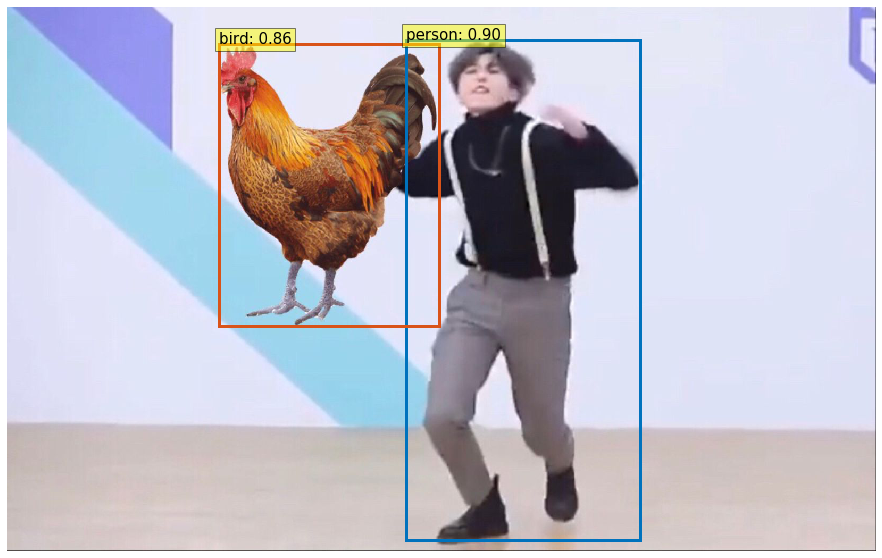

In [58]:
plot_results(im, probas[keep], bboxes_scaled)